# Movie Review Sentiment Analysis 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns

# Pre-processing

In [2]:
imdb_data = pd.read_csv("./data/imdb_dataset.csv")
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
imdb_data.isna().sum()

review       0
sentiment    0
dtype: int64

The dataset does not have any null values

<Axes: xlabel='sentiment', ylabel='count'>

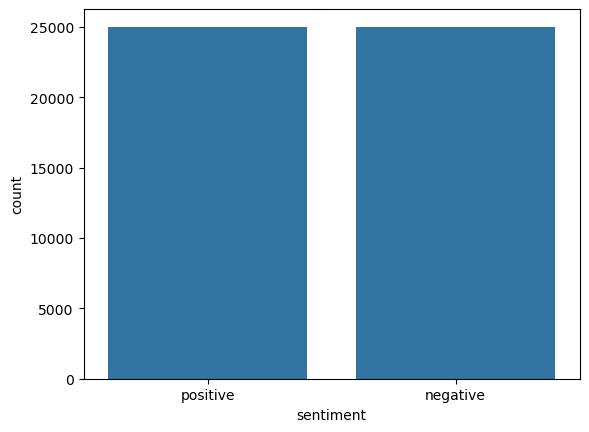

In [4]:
sns.barplot(imdb_data["sentiment"].value_counts())

The dataset is very balanced with 25000 data points each for positive and negative sentiments

In [5]:
def preprocess_reviews(reviews: pd.Series) -> pd.Series:
    # convert all values to strings
    s = reviews.astype(str)
    # replace null values with ""
    s = reviews.fillna("")
    # remove html tags
    s = s.str.replace(r"<[^>]+>", " ", regex=True)
    # collapse whitespaces and remove leading and trailing spaces
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()

    return s

In [6]:
processed_reviews = preprocess_reviews(imdb_data["review"])

In [ ]:
def tokenize(text):
    return text.lower().split()

# builds a vocabulary of words as a dictionary with the words as the keys and indices as the values
# <PAD> represents the padding token to be used to make all strings have the same length in a tensor
# <UNK> represents the unknown/rare tokens
def build_vocab(texts, min_freq=2):
    freq = {}
    for text in texts:
        for token in tokenize(text):
            freq[token] = freq.get(token, 0) + 1

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, count in freq.items():
        if count >= min_freq:
            vocab[word] = len(vocab)

    return vocab

# convert a text to a series of vocabulary indices
def encode(text, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokenize(text)]

In [ ]:
# encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(imdb_data["sentiment"])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    processed_reviews, labels, test_size=0.2, random_state=42
)

# build vocabulary from training data only
vocab = build_vocab(X_train)

# encode text
X_train_enc = [encode(text, vocab) for text in X_train]
X_test_enc = [encode(text, vocab) for text in X_test]

In [9]:
MAX_LEN = 200

def pad_sequence(seq, max_len):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [0] * (max_len - len(seq))

class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return (
            torch.tensor(pad_sequence(self.texts[idx], MAX_LEN)),
            torch.tensor(self.labels[idx], dtype=torch.float)
        )

train_ds = IMDBDataset(X_train_enc, y_train)
test_ds = IMDBDataset(X_test_enc, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out).squeeze()


In [11]:
def set_seed(seed: int = 101):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [12]:
set_seed(101)

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [14]:
model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=128
).to(DEVICE)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# training loop
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/15, Loss: 0.6917
Epoch 2/15, Loss: 0.6840
Epoch 3/15, Loss: 0.6466
Epoch 4/15, Loss: 0.6224
Epoch 5/15, Loss: 0.5862
Epoch 6/15, Loss: 0.3869
Epoch 7/15, Loss: 0.2416
Epoch 8/15, Loss: 0.1580
Epoch 9/15, Loss: 0.1010
Epoch 10/15, Loss: 0.0624
Epoch 11/15, Loss: 0.0377
Epoch 12/15, Loss: 0.0236
Epoch 13/15, Loss: 0.0207
Epoch 14/15, Loss: 0.0129
Epoch 15/15, Loss: 0.0130


In [ ]:
# testing loop
model.eval()
correct = 0
total = 0

y_true = []
y_pred = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(DEVICE), labels.to(DEVICE)
        y_true.append(labels)
        outputs = model(texts)
        preds = (outputs >= 0.5).float()
        y_pred.append(preds)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

y_true = torch.cat(y_true).detach().cpu().numpy()
y_pred = torch.cat(y_pred).detach().cpu().numpy()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8482


In [19]:
# class 0 -> "negative"
# class 1 -> "positive"
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      4961
         1.0       0.86      0.83      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

